In [7]:
import pandas as pd

df = pd.read_csv('covid_pca_finalpop.csv')

df.columns

Index(['date', 'location_key', 'inc_case', 'inc_hosp', 'inc_death',
       'sni_covid19_vaccination', 'liberalism', 'children', 'adult', 'elderly',
       'new_persons_vaccinated', 'stringency_index', 'stringency_category',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline',
       'liberalism_stringency_interaction', 'PC1', 'PC2', 'PC3',
       'Population Estimate \n(as of July 1)', 'inc_case_per_state'],
      dtype='object')

In [8]:
df['pop_proportion'] = df['Population Estimate \n(as of July 1)'] / df['inc_case']
df['interaction'] = df['liberalism'] * df['stringency_category']
df

,date,location_key,inc_case,inc_hosp,inc_death,sni_covid19_vaccination,liberalism,children,adult,elderly,...,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,liberalism_stringency_interaction,PC1,PC2,PC3,Population Estimate \n(as of July 1),inc_case_per_state,pop_proportion,interaction
0,2021-01,Alabama,112124.0,10081.0,2881.0,37.048310,0.0,2505036.0,5196985.0,2366411.0,...,-20.699692,7.784854,0.0,2.377275,-0.267974,-0.155950,5031864.0,0.022283,44.877671,0.0
1,2021-02,Alabama,37101.0,3621.0,2364.0,47.069826,0.0,2505036.0,5196985.0,2366411.0,...,-18.556306,7.211556,0.0,1.954932,-0.527701,0.001533,5031864.0,0.007373,135.626102,0.0
2,2021-03,Alabama,21389.0,1605.0,596.0,53.624391,0.0,2505036.0,5196985.0,2366411.0,...,-16.489383,3.921010,0.0,-0.147857,-0.681883,-0.173546,5031864.0,0.004251,235.254757,0.0
3,2021-04,Alabama,11826.0,1384.0,325.0,39.750964,0.0,2505036.0,5196985.0,2366411.0,...,-15.939426,2.476230,0.0,-1.072898,-0.644503,-0.262684,5031864.0,0.002350,425.491629,0.0
4,2021-05,Alabama,17507.0,1354.0,295.0,22.192073,0.0,2505036.0,5196985.0,2366411.0,...,-16.462051,2.577686,0.0,-1.289049,-0.404806,-0.361771,5031864.0,0.003479,287.420118,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,2022-01,Wyoming,30284.0,425.0,99.0,32.042965,0.0,313061.0,638520.0,275909.0,...,-18.134003,5.173077,0.0,1.811382,-1.049238,-0.186077,5896700.0,0.005136,194.713380,0.0
845,2022-02,Wyoming,10383.0,239.0,93.0,9.253333,0.0,313061.0,638520.0,275909.0,...,-14.590317,2.770833,0.0,0.685218,-1.539319,0.165393,5896700.0,0.001761,567.918713,0.0
846,2022-03,Wyoming,1147.0,60.0,65.0,7.990414,0.0,313061.0,638520.0,275909.0,...,-14.752902,1.733333,0.0,0.397872,-1.601957,0.091479,5896700.0,0.000195,5140.976460,0.0
847,2022-04,Wyoming,494.0,18.0,29.0,7.072492,0.0,313061.0,638520.0,275909.0,...,-15.437063,0.996094,0.0,0.183209,-1.348757,0.338057,5896700.0,0.000084,11936.639676,0.0


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

features = ['sni_covid19_vaccination', 'new_persons_vaccinated', 'stringency_category', 'inc_death', 
            'inc_hosp', 'children', 'adult', 'elderly', 'liberalism', 
            'interaction', 'pop_proportion', 'inc_case']
target = 'pop_proportion'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg_tree = DecisionTreeRegressor(random_state=42)
reg_tree.fit(X_train, y_train)

y_pred = reg_tree.predict(X_test)

interaction_groups = [
    (1, 1),
    (1, 2),
    (1, 3),
    (0, 1),
    (0, 2),
    (0, 3)
]

results = {}

for liberalism, stringency in interaction_groups:
    group_mask = (X_test['liberalism'] == liberalism) & (X_test['stringency_category'] == stringency)
    X_test_group = X_test[group_mask]
    y_test_group = y_test[group_mask]
    y_pred_group = reg_tree.predict(X_test_group)

    rmse = mean_squared_error(y_test_group, y_pred_group, squared=False)
    mse = mean_squared_error(y_test_group, y_pred_group)
    bias = (y_pred_group - y_test_group).mean()
    coverage = ((y_pred_group >= y_test_group.min()) & (y_pred_group <= y_test_group.max())).mean()

    results[(liberalism, stringency)] = {
        'RMSE': rmse,
        'MSE': mse,
        'Bias': bias,
        'Coverage': coverage
    }




In [10]:

results_df = pd.DataFrame(results).T.reset_index()
results_df.columns = ['Liberalism', 'Stringency Category', 'RMSE', 'MSE', 'Bias', 'Coverage']
results_df['Liberalism'] = results_df['Liberalism'].map({0: 'Conservative', 1: 'Liberal'})

pd.set_option('display.float_format', lambda x: '%.3f' % x)

results_df


,Liberalism,Stringency Category,RMSE,MSE,Bias,Coverage
0,Liberal,1,95.646,9148.137,-17.000,0.975
1,Liberal,2,2920.692,8530441.708,642.465,0.952
2,Liberal,3,335.894,112824.983,-150.737,0.800
3,Conservative,1,2069.597,4283231.948,208.315,0.987
4,Conservative,2,6.778,45.941,-1.345,0.950
5,Conservative,3,1.476,2.178,-0.990,0.800


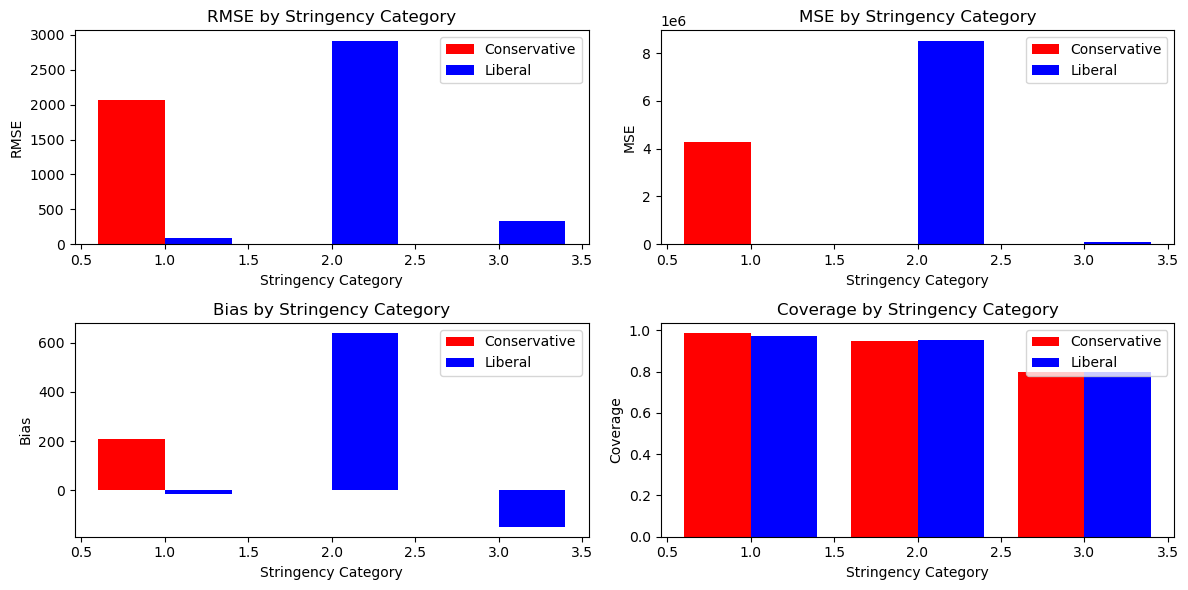

In [11]:
import matplotlib.pyplot as plt

conservative_metrics = results_df[results_df['Liberalism'] == 'Conservative']
liberal_metrics = results_df[results_df['Liberalism'] == 'Liberal']

# RMSE
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.bar(conservative_metrics['Stringency Category'] - 0.2, conservative_metrics['RMSE'], width=0.4, color='red', label='Conservative')
plt.bar(liberal_metrics['Stringency Category'] + 0.2, liberal_metrics['RMSE'], width=0.4, color='blue', label='Liberal')
plt.xlabel('Stringency Category')
plt.ylabel('RMSE')
plt.title('RMSE by Stringency Category')
plt.legend()

# MSE
plt.subplot(2, 2, 2)
plt.bar(conservative_metrics['Stringency Category'] - 0.2, conservative_metrics['MSE'], width=0.4, color='red', label='Conservative')
plt.bar(liberal_metrics['Stringency Category'] + 0.2, liberal_metrics['MSE'], width=0.4, color='blue', label='Liberal')
plt.xlabel('Stringency Category')
plt.ylabel('MSE')
plt.title('MSE by Stringency Category')
plt.legend()

# Bias
plt.subplot(2, 2, 3)
plt.bar(conservative_metrics['Stringency Category'] - 0.2, conservative_metrics['Bias'], width=0.4, color='red', label='Conservative')
plt.bar(liberal_metrics['Stringency Category'] + 0.2, liberal_metrics['Bias'], width=0.4, color='blue', label='Liberal')
plt.xlabel('Stringency Category')
plt.ylabel('Bias')
plt.title('Bias by Stringency Category')
plt.legend()

# Coverage
plt.subplot(2, 2, 4)
plt.bar(conservative_metrics['Stringency Category'] - 0.2, conservative_metrics['Coverage'], width=0.4, color='red', label='Conservative')
plt.bar(liberal_metrics['Stringency Category'] + 0.2, liberal_metrics['Coverage'], width=0.4, color='blue', label='Liberal')
plt.xlabel('Stringency Category')
plt.ylabel('Coverage')
plt.title('Coverage by Stringency Category')
plt.legend()

plt.tight_layout()
plt.show()


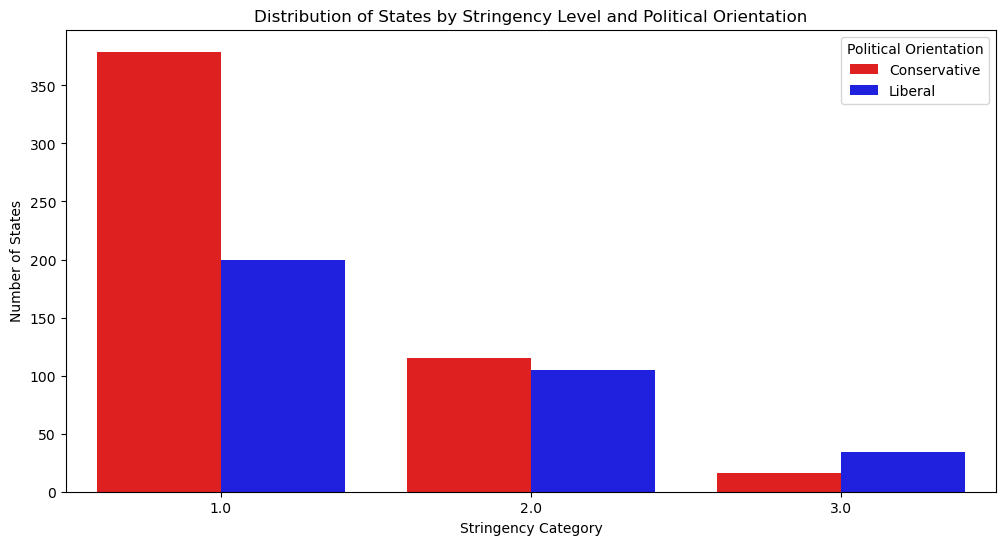

In [12]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(x='stringency_category', hue='liberalism', data=df, palette={0: 'red', 1: 'blue'})
plt.xlabel('Stringency Category')
plt.ylabel('Number of States')
plt.title('Distribution of States by Stringency Level and Political Orientation')
plt.legend(title='Political Orientation', labels=['Conservative', 'Liberal'])
plt.show()
